In [121]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter, defaultdict
from typing import Any, Callable, Iterable, List, Tuple, Union
from datetime import datetime, timezone
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [122]:
def get_freq_table(counter: Counter, max: int = 9) -> pd.DataFrame:
    table = []
    other = {"Type": "Other", "Count": 0, "Percentage": 0}
    total = sum(counter.values())
    for key, value in sorted(counter.items(), key=lambda x: x[1], reverse=True):
        if len(table) < max:
            table.append(
                {
                    "Type": key,
                    "Count": value,
                    "Percentage": f"{100 * value / total:.2f}%",
                }
            )
        else:
            other["Count"] += value
    if other["Count"] != 0:
        other["Percentage"] = f"{100 * other['Count'] / total:.2f}%"
        table.append(other)
    return pd.DataFrame(table)

In [123]:
def plot_yearly_freq(
    ax: plt.Axes,
    series: Iterable[Tuple[datetime, Any]],
    percentage: bool = False,
    max: int = 9,
    order: Union[Callable, List[str]] = lambda x: -x[1],
    palette: Union[str, List[str]] = "deep"
):
    yearly_counter = defaultdict(Counter)
    all_values = Counter()

    for date, value in series:
        yearly_counter[date.year][value] += 1
        all_values[value] += 1

    if len(all_values) > max:
        temp = Counter({k: v for k, v in all_values.most_common(max)})
        temp["Other"] = sum(all_values.values()) - sum(temp.values())
        all_values = temp
        for year, counter in yearly_counter.items():
            temp = Counter({k: counter[k] for k in all_values})
            temp["Other"] = sum(counter.values()) - sum(temp.values())
            yearly_counter[year] = temp

    if percentage:
        for year, counter in yearly_counter.items():
            yearly_counter[year] = Counter(
                {k: 100 * v / sum(counter.values()) for k, v in counter.items()}
            )

    years = sorted(yearly_counter.keys())
    counts = {}
    if isinstance(order, Callable):
        for k, _ in sorted(all_values.items(), key=order):
            counts[k] = [yearly_counter[year][k] for year in years]
    else :
        for k in order:
            counts[k] = [yearly_counter[year][k] for year in years]

    if isinstance(palette, str):
        colors = sns.color_palette(palette, len(counts))
    else:
        colors = palette
    bottom = np.zeros(len(years))
    i = 0;
    for label, count in counts.items():
        ax.bar(years, count, width=0.8, label=label, bottom=bottom, color=colors[i])
        i += 1
        bottom += count

    if percentage:
        ax.set_ylim(0, 103)
        ax.set_yticks([0, 20, 40, 60, 80, 100])
        ax.set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"])
    ax.set_xlim(years[0] - 0.7, years[-1] + 0.7)
    ax.tick_params(axis="y", labelsize=12)
    ax.tick_params(axis="x", labelsize=12)
    ax.set_xticks(range(years[0], years[-1] + 1, 2))
    ax.legend(loc="upper left")
    
    return pd.DataFrame(counts, index=years)


In [124]:
top5000_data = pd.read_csv("data/license_data.csv")
top5000_data["date"] = pd.to_datetime(top5000_data["date"])
top5000_data.head()

,package,version,date,license,license_type,which_tree,n_deps,compat
0,2to3,1.0,2018-09-07 22:44:38.117000+00:00,MIT,Permissive,tree_created,0,Compatible
1,2to3,1.0,2018-09-07 22:44:38.117000+00:00,MIT,Permissive,tree_latest,0,Compatible
2,Jinja2,2.1,2008-11-23 14:13:44+00:00,BSD-3-Clause,Permissive,tree_created,0,Compatible
3,Jinja2,2.1,2008-11-23 14:13:44+00:00,BSD-3-Clause,Permissive,tree_latest,0,Compatible
4,Jinja2,2.10,2017-11-08 20:13:42.279000+00:00,BSD-3-Clause,Permissive,tree_created,1,Unknown


In [125]:
len(top5000_data), len(set(top5000_data.package))

(48658, 4797)

In [126]:
get_freq_table(Counter(top5000_data.license))

,Type,Count,Percentage
0,MIT,20186,41.49%
1,BSD-3-Clause,10448,21.47%
2,Apache-2.0,10310,21.19%
3,Unrecognizable,2366,4.86%
4,GPL-3.0-only,898,1.85%
5,LGPL-3.0-only,882,1.81%
6,MPL-2.0,556,1.14%
7,GPL-2.0-only,430,0.88%
8,ISC,386,0.79%
9,Other,2196,4.51%


In [127]:
get_freq_table(Counter(top5000_data.license_type))

,Type,Count,Percentage
0,Permissive,41758,85.82%
1,Unknown,3110,6.39%
2,Weak Copyleft,1982,4.07%
3,Strong Copyleft,1808,3.72%


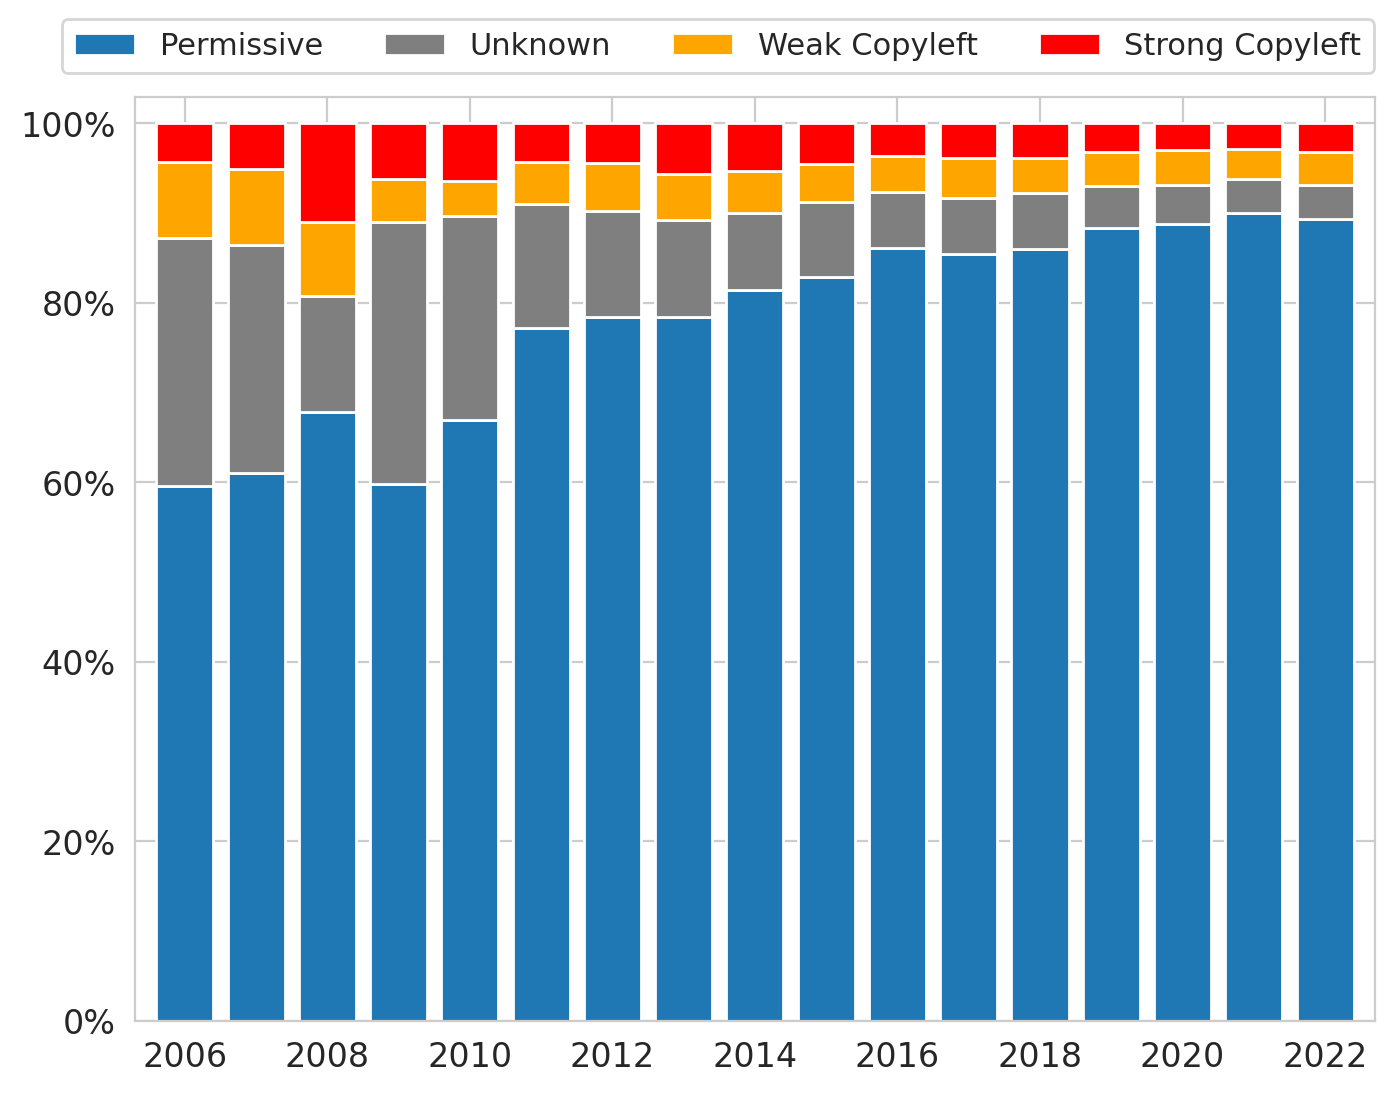

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(8, 6))
    counts=plot_yearly_freq(ax, zip(top5000_data.date, top5000_data.license_type), percentage=True,
                     order=["Permissive", "Unknown", "Weak Copyleft", "Strong Copyleft"],
                     palette=["tab:blue", "tab:gray", "orange", "r"])
    # fig.autofmt_xdate()
    ax.legend(ncol=4, loc="upper center", bbox_to_anchor=(0.47, 1.1), fontsize=11)
    fig.savefig("fig/license_type_yearly_freq_percentage.pdf", bbox_inches='tight')
    

In [129]:
print(counts)

      Permissive    Unknown  Weak Copyleft  Strong Copyleft
2006   59.574468  27.659574       8.510638         4.255319
2007   61.016949  25.423729       8.474576         5.084746
2008   67.889908  12.844037       8.256881        11.009174
2009   59.808612  29.186603       4.784689         6.220096
2010   66.969697  22.727273       3.939394         6.363636
2011   77.197150  13.776722       4.750594         4.275534
2012   78.478964  11.812298       5.339806         4.368932
2013   78.472959  10.816543       5.090138         5.620361
2014   81.487470   8.488278       4.688763         5.335489
2015   82.928431   8.338805       4.202232         4.530532
2016   86.170213   6.170213       3.989362         3.670213
2017   85.463546   6.255626       4.410441         3.870387
2018   85.958632   6.245028       3.977725         3.818616
2019   88.350877   4.631579       3.824561         3.192982
2020   88.844002   4.257303       3.977626         2.921069
2021   90.025094   3.732748       3.4190

In [130]:
all_data = pd.read_csv("data/license_data_pypi.csv")
all_data["date"] = pd.to_datetime(all_data["date"])
all_data.head()

,package,version,date,license,license_type,which_tree,n_deps,compat
0,0,0.0.0,2017-08-06 03:43:27.195000+00:00,MIT,Permissive,tree_created,0,Compatible
1,0,0.0.0,2017-08-06 03:43:27.195000+00:00,MIT,Permissive,tree_latest,0,Compatible
2,0-core-client,1.1.0a8,2017-10-11 13:19:49.816000+00:00,Apache-2.0,Permissive,tree_created,1,Compatible
3,0-core-client,1.1.0a8,2017-10-11 13:19:49.816000+00:00,Apache-2.0,Permissive,tree_latest,6,Compatible
4,0-orchestrator,1.1.0a8,2017-10-11 13:21:48.015000+00:00,Apache-2.0,Permissive,tree_created,7,Unknown


In [131]:
get_freq_table(Counter(all_data.license_type))

,Type,Count,Percentage
0,Permissive,851144,62.14%
1,Unknown,279192,20.38%
2,Strong Copyleft,200908,14.67%
3,Weak Copyleft,38414,2.80%


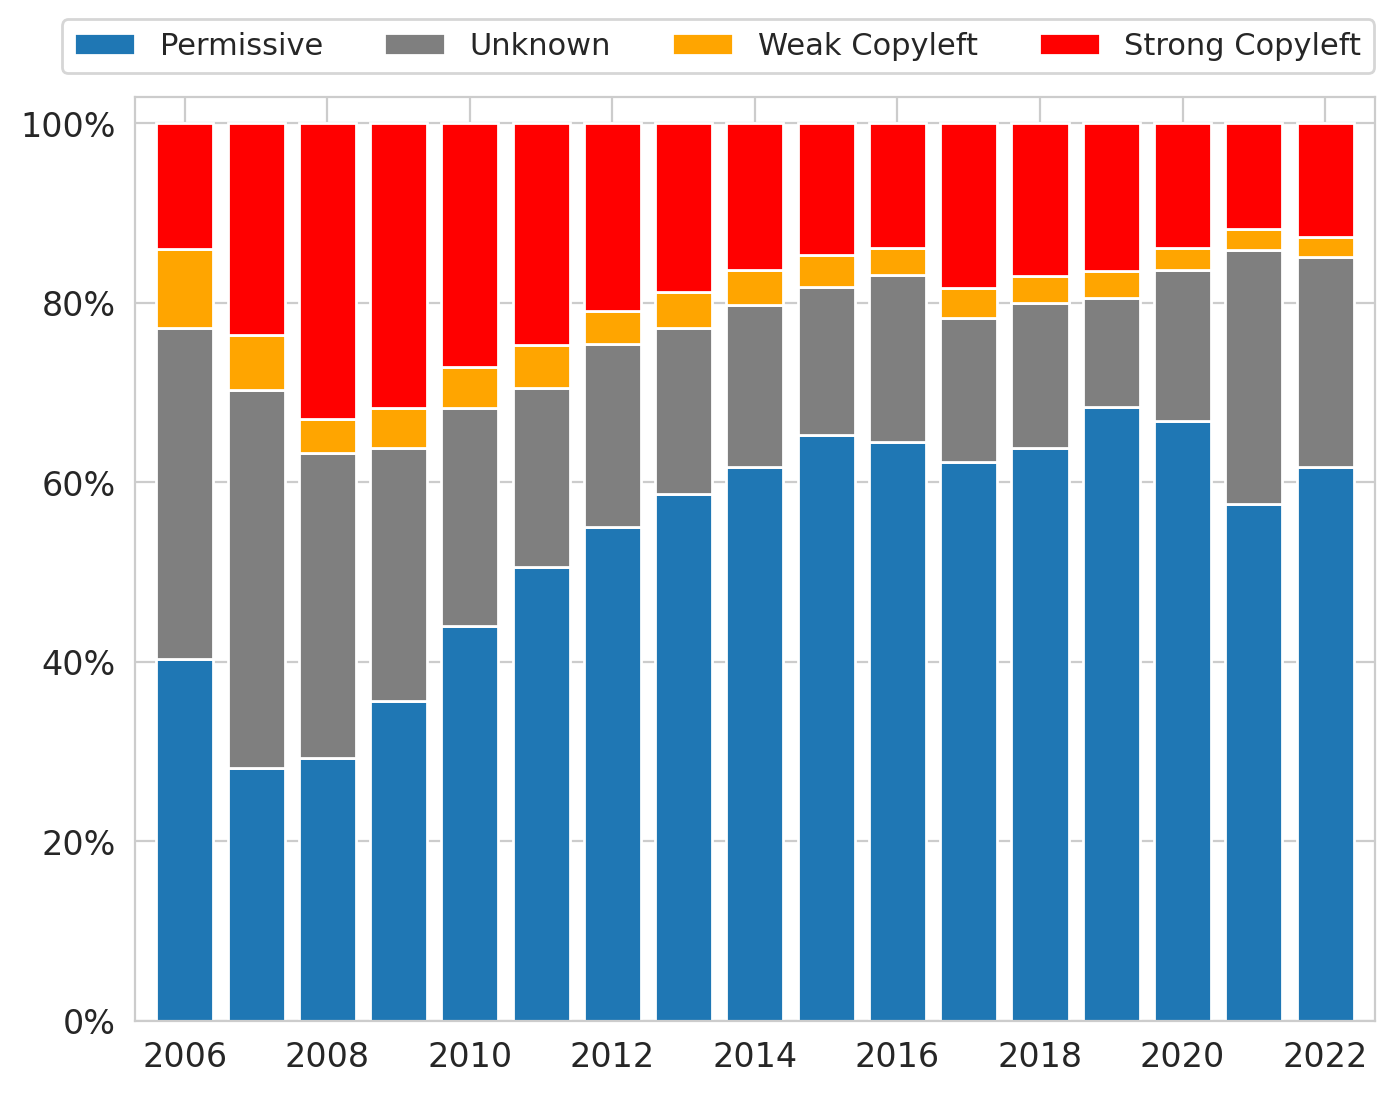

In [132]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(8, 6))
    counts=plot_yearly_freq(ax, zip(all_data.date, all_data.license_type), percentage=True,
                    order=["Permissive", "Unknown", "Weak Copyleft", "Strong Copyleft"],
                    palette=["tab:blue", "tab:gray", "orange", "r"])
    # fig.autofmt_xdate()
    ax.legend(ncol=4, loc="upper center", bbox_to_anchor=(0.47, 1.1), fontsize=11)
    fig.savefig("fig/license_type_yearly_freq_percentage_pypi.pdf", bbox_inches='tight')

In [133]:
print(counts)

      Permissive    Unknown  Weak Copyleft  Strong Copyleft
2006   40.355330  36.802030       8.883249        13.959391
2007   28.166160  42.147923       6.079027        23.606890
2008   29.271845  33.980583       3.834951        32.912621
2009   35.574393  28.295820       4.384683        31.745104
2010   43.976632  24.294923       4.633360        27.095085
2011   50.604027  19.925429       4.787472        24.683072
2012   55.049585  20.329893       3.713823        20.906699
2013   58.690074  18.474004       4.017556        18.818366
2014   61.706672  18.032954       3.961554        16.298820
2015   65.286320  16.441915       3.587118        14.684647
2016   64.479584  18.667424       3.025049        13.827943
2017   62.311210  15.985405       3.318553        18.384832
2018   63.861138  16.099867       3.053988        16.985006
2019   68.403927  12.137674       2.995276        16.463124
2020   66.802446  16.825179       2.539597        13.832778
2021   57.529971  28.353834       2.3529

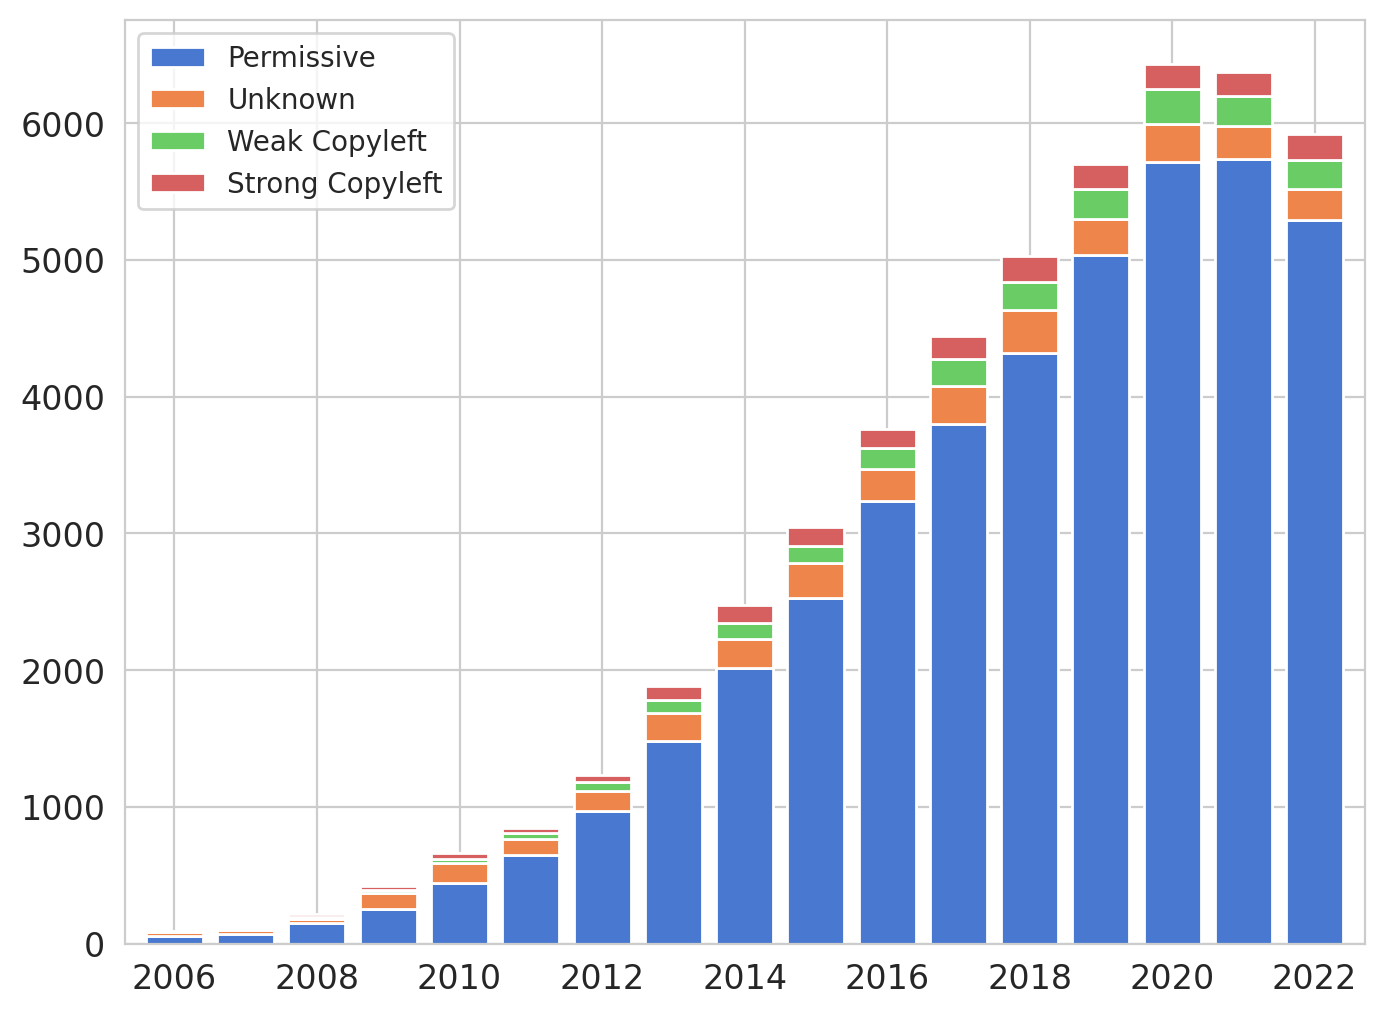

In [134]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(8, 6))
    plot_yearly_freq(ax, zip(top5000_data.date, top5000_data.license_type), percentage=False, palette="muted")
    # fig.autofmt_xdate()
    fig.savefig("fig/license_type_yearly_freq.pdf", bbox_inches='tight')

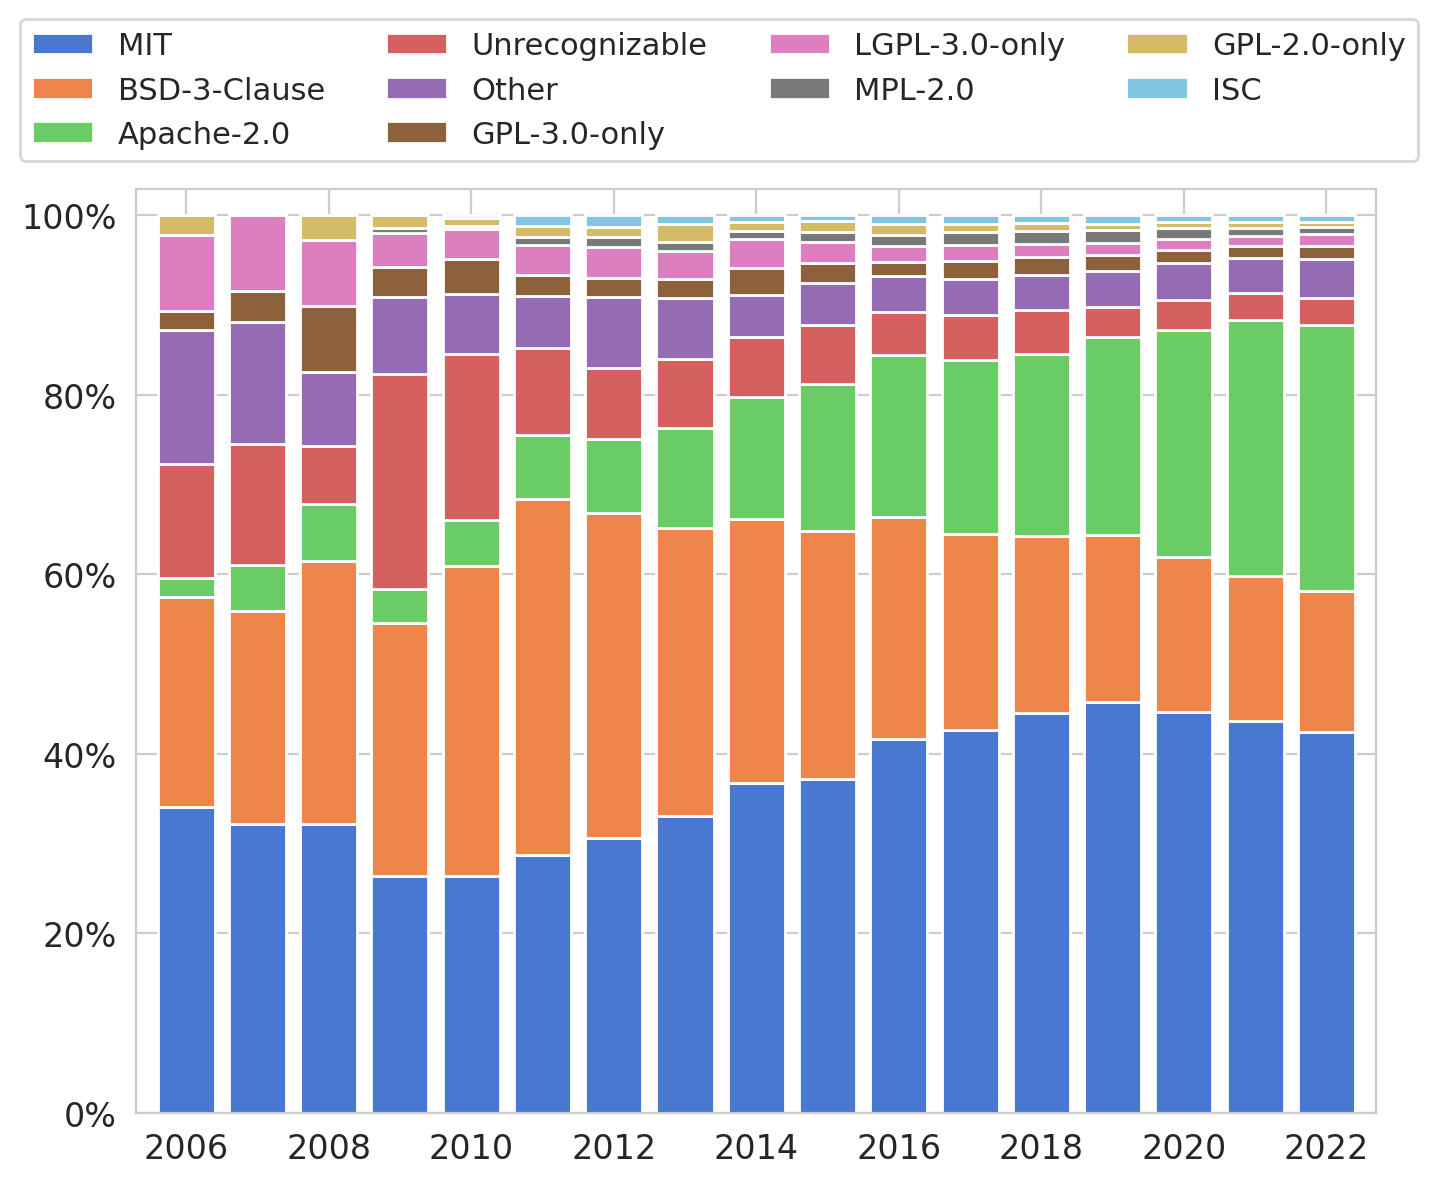

In [135]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(8, 6))
    plot_yearly_freq(ax, zip(top5000_data.date, top5000_data.license), percentage=True, palette="muted")
    # fig.autofmt_xdate()
    ax.legend(ncol=4, loc="upper center", bbox_to_anchor=(0.47, 1.2), fontsize=11)
    fig.savefig("fig/license_yearly_freq_percentage.pdf", bbox_inches='tight')


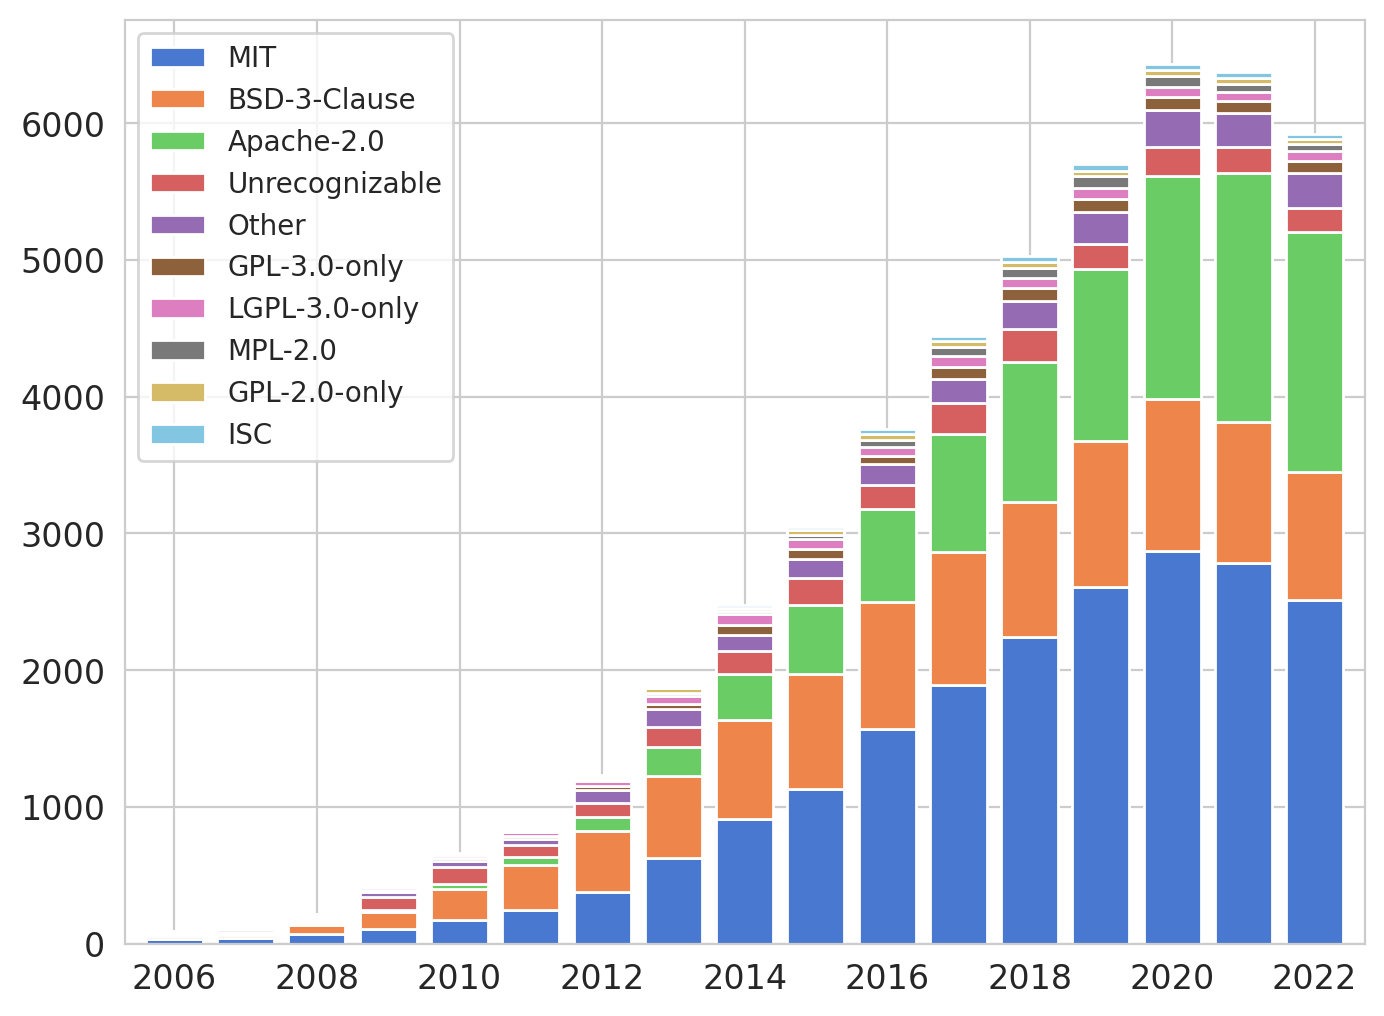

In [136]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(8, 6))
    plot_yearly_freq(ax, zip(top5000_data.date, top5000_data.license), percentage=False, palette="muted")
    # fig.autofmt_xdate()
    fig.savefig("fig/license_yearly_freq.pdf", bbox_inches='tight')

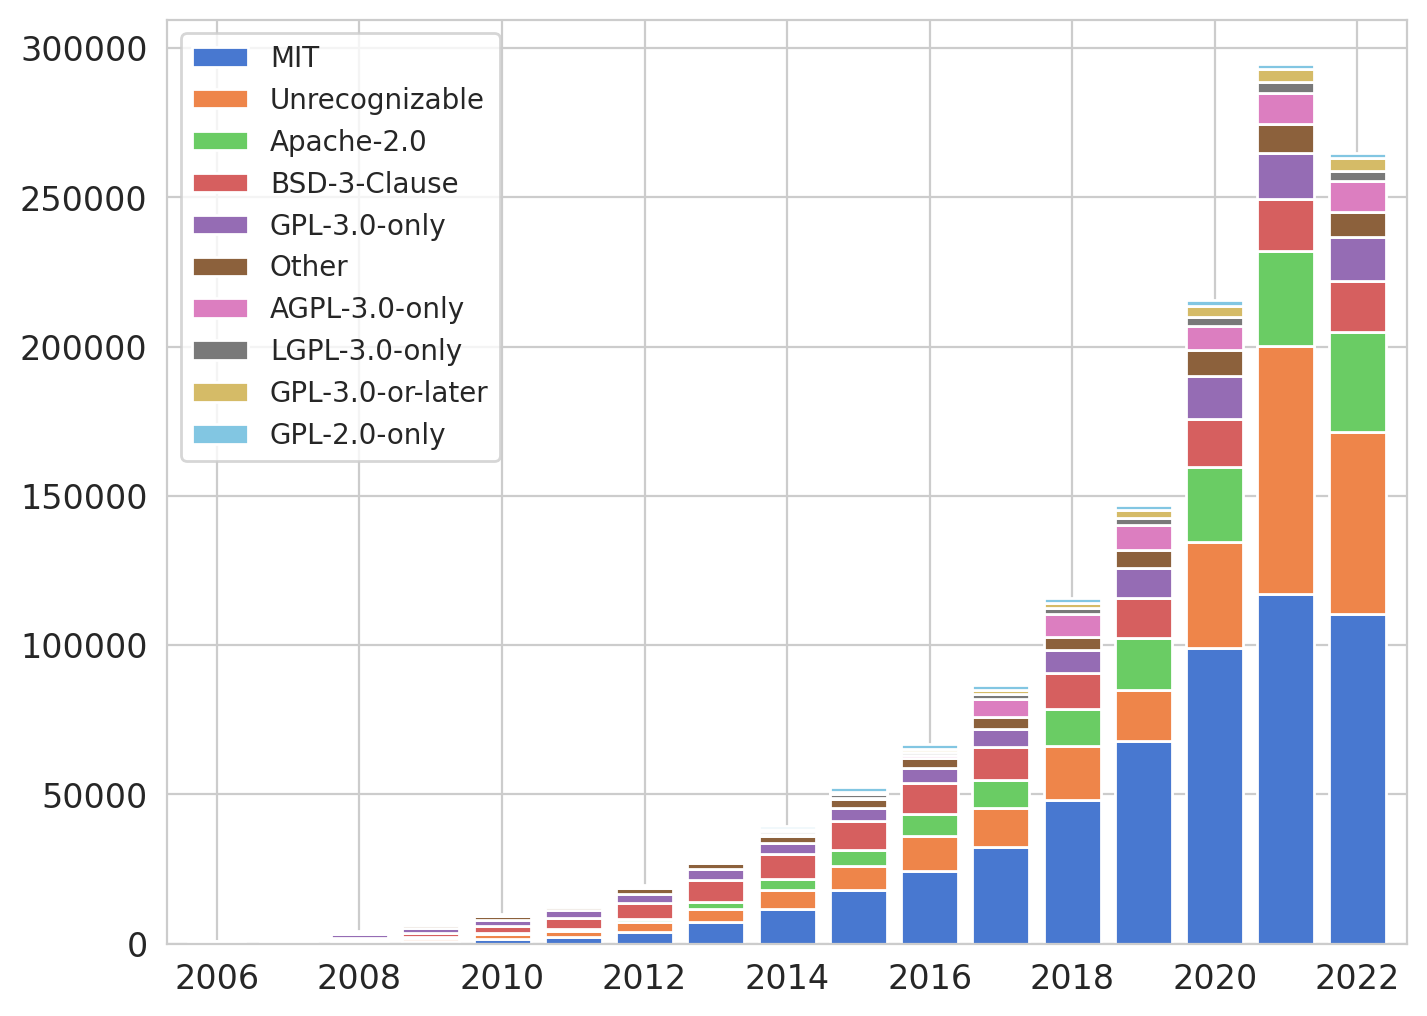

In [137]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(8, 6))
    plot_yearly_freq(ax, zip(all_data.date, all_data.license), percentage=False, palette="muted")
    # fig.autofmt_xdate()
    fig.savefig("fig/license_yearly_freq_pypi.pdf", bbox_inches='tight')